In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In this notebook I will reuse the functions below, copied from notebook 5.

In [1093]:
# functions defined on notebook 5

import re
import unicodedata, string

def namesFromString( namesStr, splitOn=';', unique=False, preserveOrder=False ):
    if type(splitOn)==str:
        namesSplit = namesStr.split(splitOn)
        
    elif type(splitOn)==list:
        namesSplit = re.split( '|'.join( c for c in splitOn ) ,namesStr)
    
    namesList = [ n for n in [ name.strip() for name in namesSplit ] if n!='' ]
    
    if unique:
        if not preserveOrder: return list(set(namesList))
        else:
            namesCounts = dict( (n,0) for n in namesList )
            unique_namesList = []
            for n in namesList:
                if namesCounts[n]: continue
                namesCounts[n]+=1
                unique_namesList.append(n)
        return unique_namesList   
    
    return namesList


def normalize(name, normalizationForm='NFKD'):
    name = name.lower() # to lowecase
    name = name.replace('.','') # remove periods
    name_ls = tuple( part.strip() for part in name.split(',') ) # split and strip names into tuples

    normalize = lambda s: ''.join( x for x in unicodedata.normalize(normalizationForm, s) if x in string.ascii_letters ) # remove accents
    name_ls = tuple( normalize(name) for name in name_ls )
    
    return ','.join(name_ls)

In [2]:
datasetpath = '/home/pedro/datasets/jbrj_herbarium/occurrence.txt'

In [561]:
colnames = ['recordedBy', 'taxonRank', 'scientificName', 'eventDate',
            'occurrenceID', 'collectionCode', 'stateProvince', 
            'locality', 'countryCode', 'county']
occs = pd.read_csv(datasetpath, sep='\t', usecols=colnames)

Here I'm interested in records from the Itatiaia municipality with information about the collectors.

In [1085]:
occs_itatiaia = occs[occs['county'].apply(lambda x: 'Itatiaia' in str(x))]
occs_itatiaia = occs_itatiaia[occs_itatiaia['recordedBy'].notnull()]

In [1084]:
occs_itatiaia.head(10)

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank
169,RB,urn:catalog:JBRJ:RB:327442,R.W.Kaempfe,1931-03-03,BR,Rio de Janeiro,Itatiaia,Serra da Mantiqueira.,ROSACEAE Fragaria,genus
225,RB,urn:catalog:JBRJ:RB:379779,P. Campos Porto,1918-08-20,BR,Rio de Janeiro,Itatiaia,Lactiferos.,SAPOTACEAE,family
306,ITA,urn:catalog:JBRJ:RB:477401,José Adaltro Lemes,1977-10-04,BR,Rio de Janeiro,Itatiaia,Macieiras.,SYMPLOCACEAE,family
310,ITA,urn:catalog:JBRJ:RB:478924,J. J. Sampaio,1942-09-25,BR,Rio de Janeiro,Itatiaia,Repouso Itatiaiai.,SOLANACEAE Solanum,genus
408,RUSU,urn:catalog:JBRJ:RB:679739,"Camerik, A.M.",1975-04-23,BR,Rio de Janeiro,Itatiaia,NaN,AQUIFOLIACEAE Ilex,genus
514,RB,urn:catalog:JBRJ:RB:554980,M. Salazar Yepes,NaN,BR,Rio de Janeiro,Itatiaia,"PARNA-Itatiaia, trilha três Picos.",INDETERMINADA,family
517,RB,urn:catalog:JBRJ:RB:560431,M. Salazar Yepes & A.A. Carvalho Jr.,NaN,BR,Rio de Janeiro,Itatiaia,"PARNA-Itatiaia, na estrada Portaria Principal-...",INDETERMINADA,family
705,RB,urn:catalog:JBRJ:RB:1006065,M. Salazar Yepes & A.A. Carvalho Jr.,2007-8-7,BR,Rio de Janeiro,Itatiaia,NaN,PUCCINIALES Phakopsora rossmanii,specie
741,RB,urn:catalog:JBRJ:RB:145779,A. Mello,NaN,BR,Rio de Janeiro,Itatiaia,NaN,LEGUMINOSAE Melanoxylon brauna Schott,specie
1253,ITA,urn:catalog:JBRJ:RB:477461,P. C. Porto,1918,BR,Rio de Janeiro,Itatiaia,NaN,SAPINDACEAE,family


Let's first create a `collectors_split` column, which stores the atomized collectors names as extracted by an `atomizeNames` expression.

Here I'll work only with **collaborative records**, which were obtained by more than one collector

The percentage of collaborative records on the dataset from Itatiaia is relatively low:

In [302]:
"Percentage of collaborative records at Itatiaia: {:.2%}".format(
    occs_itatiaia_collaborative.shape[0]/occs_itatiaia.shape[0])

'Percentage of collaborative records at Itatiaia: 8.03%'

---

Let's get a list of names of collaborative collectors in Itatiaia. I'll only show the first ten elements:

From these names I can then build a names map, which maps each variation of a name to its normal form. I'll show the first ten elements mapped.

Now, we can inspect the names map and verify that some variations actually belong to the same entity. I'll use the function below to remap normalized names in the names map. The function takes a remapping dictionary and the names map to be modified and performs the remapping inplace.

---

---

## Atomizing names

In [722]:
def atomizeNames( df, colName, atomizingFunction, recordsIndex=None, atomizedColName=None  ):
    if not atomizedColName:
        atomizedColName = colName+"_atomized"
    
    if recordsIndex:
        df.loc[recordsIndex,atomizedColName] = df.loc[recordsIndex,colName].apply( atomizingFunction )
    else: # atomize the entire dataframe
        df.loc[:,atomizedColName] = df.loc[:,colName].apply( atomizingFunction )

In [723]:
atomizingOperation = lambda ns: namesFromString(ns, splitOn=['&',';',' e ']) 

atomizeNames(occs_itatiaia, 'recordedBy', atomizingOperation)
occs_itatiaia.head()

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank,recordedBy_atomized
169,RB,urn:catalog:JBRJ:RB:327442,R.W.Kaempfe,1931-03-03,BR,Rio de Janeiro,Itatiaia,Serra da Mantiqueira.,ROSACEAE Fragaria,genus,[R.W.Kaempfe]
225,RB,urn:catalog:JBRJ:RB:379779,P. Campos Porto,1918-08-20,BR,Rio de Janeiro,Itatiaia,Lactiferos.,SAPOTACEAE,family,[P. Campos Porto]
306,ITA,urn:catalog:JBRJ:RB:477401,José Adaltro Lemes,1977-10-04,BR,Rio de Janeiro,Itatiaia,Macieiras.,SYMPLOCACEAE,family,[José Adaltro Lemes]
310,ITA,urn:catalog:JBRJ:RB:478924,J. J. Sampaio,1942-09-25,BR,Rio de Janeiro,Itatiaia,Repouso Itatiaiai.,SOLANACEAE Solanum,genus,[J. J. Sampaio]
408,RUSU,urn:catalog:JBRJ:RB:679739,"Camerik, A.M.",1975-04-23,BR,Rio de Janeiro,Itatiaia,NaN,AQUIFOLIACEAE Ilex,genus,"[Camerik, A.M.]"


## The NamesMap class

In [724]:
from copy import deepcopy

class NamesMap:
    _map=None
    _normalizationFunction=None
    _remappingDict=None
    
    def __init__(self, names, normalizationFunction):
        self._normalizationFunction = normalizationFunction
        self._map = dict( (n, self._normalizationFunction(n)) for n in names )
        return
    
    def clearMap(self):
        self._map={}
    
    def remap(self, remappingDict):
        if self._remappingDict is None:
            self._remappingDict = remappingDict
        else:
            self._remappingDict.update(remappingDict)
        return     
    
    def insertNames(self, names, normalizationFunction=None, rebuild=False):
        # if rebuild is true, the entire map (but not the remapping dict) is rebuilt from scratch
        if rebuild==True:
            self.clearMap()
        if normalizationFunction is None: 
            normalizationFunction = self._normalizationFunction
        self._map.update( dict( (n,normalizationFunction(n)) for n in names ) )
        return
    
    def removeNames(self, names):
        # removes names from the map 
        pass
    
    def getMap(self, remap=True):
        # Returns a COPY of the map
        # If remap is set to true, some remapping occurrs
        res = deepcopy(self._map)
        if remap and self._remappingDict is not None:
            getNamesPrimitives = lambda n: ( name for name,norm in self._map.items() if norm == n )
            for n,t in ( (n,t) for s,t in self._remappingDict.items() for n in getNamesPrimitives(s) ):
                res[n]=t
        return res
    
    def getNormalizedNames(self, remap=True):
        return sorted(list(set(self.getMap(remap=remap).values())))
    
    def getNamePrimitives(self, n):
        nmap = self.getMap()
        return [ name for name,norm in nmap.items() if norm == n ]
        

---

In [725]:
occs_itatiaia_collaborative = occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda l: len(l)>1)]
namesList = sorted(list(set( n for nlst in occs_itatiaia_collaborative['recordedBy_atomized'] for n in nlst )))

# create names map
nm = NamesMap(namesList, normalize)
remappingDict = {
    'aacarvalhojr': 'aacarvalho',
    'aparicio': 'apparicio',
    'brade': 'brade,ac',
    'fidalgo,k': 'kauffmannfidalgo',
    'fildalgo': 'oswaldofidalgo',
    'fidalgo': 'oswaldofidalgo',
    'kauffmannfidalfoeg': 'kauffmannfidalgo',
    'mekauffmannfidalgo': 'kauffmannfidalgo',
    'kfidalgo': 'kauffmannfidalgo',
    'lanstsyak,l': 'lanstyak,l',
    'fidalgo,o': 'oswaldofidalgo',
    'ofidalgo': 'oswaldofidalgo',
    'silveira,o': 'silveiramelo,o',
    'tamandare': 'tamandaredetoledo',
    'toledo': 'tamandaredetoledo',
    'pjmmaas': 'pjmaas',
    'pjlmaas': 'pjmaas',
    'acbrade': 'brade,ac',
}
nm.remap(remappingDict)
nm.remap({'profpilger':'pilger'})

In [726]:
nm.getMap()

{'A. C. Brade': 'brade,ac',
 'A.A. Carvalho Jr.': 'aacarvalho',
 'A.A.Carvalho': 'aacarvalho',
 'A.C.Mota': 'acmota',
 'Aparicio': 'apparicio',
 'Apparicio': 'apparicio',
 'Brade': 'brade,ac',
 'Brade, A. C.': 'brade,ac',
 'C.M. Sakuragui': 'cmsakuragui',
 'D. P. Costa': 'dpcosta',
 'D.P.Costa': 'dpcosta',
 'Ed. Pereira, Egle,': 'edpereira,egle,',
 'Edmundo': 'edmundo',
 'F. Santoro': 'fsantoro',
 'F. Toledo Jr.': 'ftoledojr',
 'Fidalgo, K.': 'kauffmannfidalgo',
 'Fidalgo, O.': 'oswaldofidalgo',
 'Fildalgo': 'oswaldofidalgo',
 'G. Martinelli': 'gmartinelli',
 'Graziela': 'graziela',
 'I. França': 'ifranca',
 'K.Fidalgo': 'kauffmannfidalgo',
 'Kauffmann Fidalfo Eg-07': 'kauffmannfidalgo',
 'Kauffmann Fidalgo': 'kauffmannfidalgo',
 'L. C. S. Giordano': 'lcsgiordano',
 'L. S. Sylvestre': 'lssylvestre',
 'L.A.F': 'laf',
 'Lanstsyak, L.': 'lanstyak,l',
 'Lanstyak, L.': 'lanstyak,l',
 'Luiz': 'luiz',
 'M. Barros': 'mbarros',
 'M. Salazar Yepes': 'msalazaryepes',
 'M. Salazar Yepes, A.A. Carv

---

Now let's get a **names index** which stores the ids of the rows where each normalized name appears:

But it turns out that some of the names are still not normalized, as it is the case of `'msalazaryepes,aacarvalhojr'`:

In that case an alternative is to renormalize some records and get another names from the updated normalized names column:

## Reatomizing records

### Names index

In [727]:
def getNamesIndexes( df, atomizedNamesCol, namesMap=None ):
    # split_names_col is a column with names already split
    namesIndexes = dict( (name,[]) for name in namesMap.values() )
    for i,names in df[atomizedNamesCol].iteritems():
        for name in names:
            if namesMap is not None:
                try:
                    namesIndexes[namesMap[name]].append(i)
                except KeyError:
                    pass
            else:
                namesIndexes[name].append(i)
            
    return namesIndexes

In [728]:
ni = getNamesIndexes(occs_itatiaia, 'recordedBy_atomized', nm.getMap())

These records are the ones to be atomized

In [729]:
names_to_atomize = ['msalazaryepes,aacarvalhojr', 'edpereira,egle,' ]

In [730]:
atomizingOperation = lambda l: [ n for name in l for n in namesFromString(name,',')]

for n in names_to_atomize:
    atomizeNames(occs_itatiaia,'recordedBy_atomized',atomizingOperation,ni[n], 'recordedBy_atomized')

Now we rebuild the names map, while keeping the remapping dictionary

In [731]:
occs_itatiaia_collaborative = occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda l: len(l)>1)]
namesList = sorted(list(set( n for nlst in occs_itatiaia_collaborative['recordedBy_atomized'] for n in nlst )))

In [732]:
nm.insertNames(namesList,rebuild=True)
ni = getNamesIndexes(occs_itatiaia, 'recordedBy_atomized', nm.getMap())

---

## Joining names

Some records should not have been atomized:

In [733]:
occs_itatiaia_collaborative.loc[ni['laf']]

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank,recordedBy_atomized
64066,RB,urn:catalog:JBRJ:RB:573945,L.A.F; Santos Filho,2009-09-21,BR,Rio de Janeiro,Itatiaia,Em fragmento florestal no Alto dos Brejos. Par...,MELASTOMATACEAE Tibouchina,genus,"[L.A.F, Santos Filho]"


In [734]:
def mergeNames( df, colName, joiningFunction, recordsIndex ):
    df.loc[recordsIndex,colName] = df.loc[recordsIndex,colName].apply(joiningFunction)

In [735]:
joinOp = lambda l: [','.join(l)]
mergeNames( occs_itatiaia, 'recordedBy_atomized',joinOp, ni['laf'] )

In [744]:
occs_itatiaia_collaborative = occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda l: len(l)>1)]
namesList = sorted(list(set( n for nlst in occs_itatiaia_collaborative['recordedBy_atomized'] for n in nlst )))
nm.insertNames(namesList,rebuild=True)
ni = getNamesIndexes(occs_itatiaia, 'recordedBy_atomized', nm.getMap())

In [747]:
nm.getNormalizedNames()

['aacarvalho',
 'acmota',
 'apparicio',
 'brade,ac',
 'cmsakuragui',
 'dpcosta',
 'edmundo',
 'edpereira',
 'egle',
 'fsantoro',
 'ftoledojr',
 'gmartinelli',
 'graziela',
 'ifranca',
 'kauffmannfidalgo',
 'lanstyak,l',
 'lcsgiordano',
 'lssylvestre',
 'luiz',
 'mbarros',
 'mdmviannafilho',
 'mpmdelima',
 'msalazaryepes',
 'occhioni,p',
 'oswaldofidalgo',
 'pilger',
 'pjmaas',
 'silveiramelo,o',
 'srgradstein',
 'ssalgado',
 'tamandaredetoledo']

---

# Building the network

In [840]:
import networkx
import itertools
from collections import Counter

class CoworkingNetwork(networkx.Graph):
    """
    Class for coworking networks. Extends networkx Graph class.
    
    Parameters
    ----------
    namesSets : iterable
        An iterable of iterables containing names used to compose cliques 
        in the network.

    weighted : bool, default False
        If set to True the resulting network will have weighted edges
        
    Examples
    --------
    >>> namesSets = [ ['a','b','c'], ['d','e'], ['a','c'] ]
    >>> CoworkingNetwork( namesSets, weighted=True).edges(data=True)
    [('b', 'a', {'weight': 1}),
     ('b', 'c', {'weight': 1}),
     ('a', 'c', {'weight': 2}),
     ('e', 'd', {'weight': 1})]
    
    >>> CoworkingNetwork( namesSets ).edges(data=True)
    [('b', 'a', {}), 
     ('b', 'c', {}), 
     ('a', 'c', {}), 
     ('e', 'd', {})]
    """
    def __init__(self, namesSets, weighted=False):
        super().__init__()
        cliques = map( lambda n: itertools.combinations(n,r=2), namesSets )
        edges = [ e for edges in cliques for e in edges ]
        self.add_edges_from(edges)
        
        if weighted:
            edges_weights = Counter(edges)

            for (u,v),w in edges_weights.items():
                try:
                    self[u][v]['weight'] += w
                except:
                    self[u][v]['weight'] = w        
        return

In [856]:
m = nm.getMap()
names = ([ m[n] for n in names ] for names in occs_itatiaia_collaborative['recordedBy_atomized'])
G = CoworkingNetwork( names, weighted=True)

In [858]:
G.nodes(data=True)

[('msalazaryepes', {}),
 ('aacarvalho', {}),
 ('cmsakuragui', {}),
 ('fsantoro', {}),
 ('ifranca', {}),
 ('brade,ac', {}),
 ('lanstyak,l', {}),
 ('edpereira', {}),
 ('egle', {}),
 ('graziela', {}),
 ('apparicio', {}),
 ('edmundo', {}),
 ('dpcosta', {}),
 ('srgradstein', {}),
 ('mdmviannafilho', {}),
 ('acmota', {}),
 ('oswaldofidalgo', {}),
 ('kauffmannfidalgo', {}),
 ('silveiramelo,o', {}),
 ('occhioni,p', {}),
 ('luiz', {}),
 ('mpmdelima', {}),
 ('mbarros', {}),
 ('pilger', {}),
 ('tamandaredetoledo', {}),
 ('pjmaas', {}),
 ('gmartinelli', {}),
 ('ftoledojr', {}),
 ('lssylvestre', {}),
 ('lcsgiordano', {}),
 ('ssalgado', {})]

Set the number of records at itatiaia as the `n_records` attribute for each collector

In [871]:
nrecords = dict( (n,len(ix)) for n,ix in getNamesIndexes(occs_itatiaia,'recordedBy_atomized',m).items() )
nx.set_node_attributes(G, 'n_records',nrecords)

In [875]:
nx.write_gexf(G,'./graph.gexf')

In [878]:
import matplotlib.pyplot as plt
%matplotlib inline

In [982]:
G.nodes(data=True).g

AttributeError: 'list' object has no attribute 'get'

In [999]:
sorted(tuple(G.nodes(data=True)), key=lambda x: x[1]['n_records'], reverse=True )

[('msalazaryepes', {'n_records': 1215}),
 ('aacarvalho', {'n_records': 1149}),
 ('brade,ac', {'n_records': 911}),
 ('ifranca', {'n_records': 161}),
 ('oswaldofidalgo', {'n_records': 110}),
 ('dpcosta', {'n_records': 103}),
 ('fsantoro', {'n_records': 100}),
 ('cmsakuragui', {'n_records': 79}),
 ('mpmdelima', {'n_records': 67}),
 ('kauffmannfidalgo', {'n_records': 42}),
 ('lanstyak,l', {'n_records': 41}),
 ('apparicio', {'n_records': 37}),
 ('luiz', {'n_records': 37}),
 ('tamandaredetoledo', {'n_records': 34}),
 ('gmartinelli', {'n_records': 26}),
 ('edpereira', {'n_records': 25}),
 ('srgradstein', {'n_records': 21}),
 ('occhioni,p', {'n_records': 15}),
 ('pjmaas', {'n_records': 14}),
 ('graziela', {'n_records': 4}),
 ('ftoledojr', {'n_records': 4}),
 ('edmundo', {'n_records': 3}),
 ('pilger', {'n_records': 3}),
 ('silveiramelo,o', {'n_records': 2}),
 ('lssylvestre', {'n_records': 2}),
 ('egle', {'n_records': 1}),
 ('mdmviannafilho', {'n_records': 1}),
 ('acmota', {'n_records': 1}),
 ('

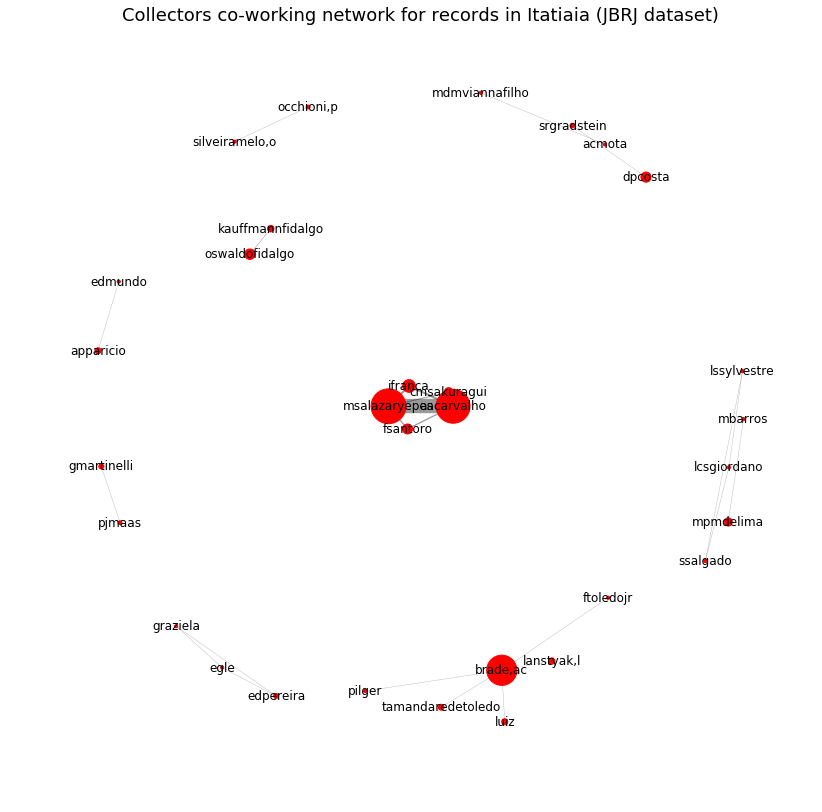

In [1082]:
lt = nx.layout.spring_layout(G)
pos = {
 'msalazaryepes': (0.45,0.5),
 'aacarvalho': (0.55,0.5)
}
lt.update(pos)

edges = G.edges()
edges_weights = [ G.edge[u][v]['weight'] for u,v in edges ]
nodes = G.nodes()
nodes_sizes = [ G.node[n]['n_records'] for n in nodes ]

plt.figure(figsize=(14,14))
plt.title('Collectors co-working network for records in Itatiaia (JBRJ dataset)', fontsize=18)
plt.axis('off')
nx.draw_networkx_nodes(G, lt, nodes, node_size=[10 if s<=10 else s for s in nodes_sizes])
nx.draw_networkx_labels(G, lt, font_color='k')
nx.draw_networkx_edges(G, lt, edges, width=[ 0.3 if w<=10 else w/80 for w in edges_weights], alpha=0.4 )

plt.show()